# Optimizing Portfolio - Technical Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
aspect_ratio = (12, 8)

# 1. Reading the datasets

Functions helpful for technical analysis

In [2]:
def read_price_data(filename, index_col = 0, parse_dates = True):
    """ Function to read the data frame from the csv file"""
    # dayfirst=True makes the input format to be "dd/mm/yyyy"
    df_stock = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates, dayfirst=False)
    # stripping the csv to display the stock ticker
    stock_name = filename.strip('.csv')
    print(f'Information about the Stock: {stock_name}')
    # Information about Dataframe
    print(df_stock.info())
    print(f'\n')
    print(f'Null elements in the dataframe for stock: {stock_name}')
    # check for nulls
    print(df_stock.isnull().sum())
    print(f'\n')
    print(f'Summary Statistics for the Stock: {stock_name}')
    # summary statistics for the dataframe
    print(df_stock.describe())
    print(f'Dataframe of the Stock: {stock_name}')
    print(f'\n')
    # dataframe
    print(df_stock)
    print(f'\n\n\n')
    return(df_stock)

def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(),
                           aspect_ratio=(12, 8), title="", ylabel="", grid=True):
    """ Function to plot the dataframe columns based on the formatter and format the plot using the given fields """
    plt.figure(figsize=aspect_ratio)
    # Plot every column of the dataframe indivisually
    for col in data_frame.columns:
        plt.plot(data_frame.index, data_frame[col], label=col)
    # turn grid ON
    plt.grid(grid)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    #formatting y-axis Get_Current_Axis and use the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend()
    plt.show()

def print_pct_data(data_frame, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    """ Pretty print the dataframe. Convert the returns to percentages. """
    # Applying the format and na_rep using the Styler
    if index_slice:
        return data_frame.style.format(format_spec, subset=index_slice, na_rep=na_rep)
    else:
        return data_frame.style.format(format_spec, na_rep=na_rep)

def calcSummaryStatistics(returns, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}"):
    """ Calculate the summary statistics from the returns dataframe. Use annualization factor to determine the conversion factor to 
    convert the daily/monthly returns to annual returns, and pretty print the results."""
    # Checking if the first row contains values [Only True if all the columns in first row has values]
    if returns.iloc[0].notna().all():
        # Inserting a row of NaN values at the top of the dataframe with the correct business date
        Nan_date = pd.date_range(end=returns.index[0], periods=2, freq='B')[0]
        new_row = pd.DataFrame(index=[Nan_date], columns=returns.columns)
        returns = pd.concat([new_row, returns])
    
    # This condition is True when one or more columns in the first row contain NaN
    else:
        # Check whether first row is a mixture of NaN and values. This is True only when first row contains atleast one value
        if not returns.iloc[0].isnull().all():
            raise ValueError("First row should contain NaN values for all columns.")

    # Check if there are NaN values in non-first rows, if yes, raise ValueError
    if returns.iloc[1:].isnull().values.any():
        raise ValueError("NaN rows should only be in the first row")
    
    
    # Calculate cumulative returns (NAV)
    cumulative_returns = (1 + returns).cumprod().fillna(1)

    summary_stats = pd.DataFrame([annualization_factor*returns.mean(), 
                              np.sqrt(annualization_factor)*returns.std(),
                              np.sqrt(annualization_factor) * returns.mean() / returns.std(),
                              (cumulative_returns - np.maximum.accumulate(cumulative_returns)).min(axis = 0),
                              (returns.dropna() >= 0).sum() / returns.dropna().shape[0]],
                              index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])
    
    if print_screen:
        print("Summary Statistics for Returns:")
        display(print_pct_data(summary_stats, 
                               format_spec=percent_format_string,
                               index_slice = pd.IndexSlice[['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio'], :]))
    else:
        return summary_stats
        
        
def movingAverageCrossover(stock_data, fastWindow, slowWindow):
    """ Takes input of single instrument. This function will implement 3 strategies, one which goes flat moving average, 
    one which goes short moving average, and one with the original daily returns (Benchmark). It calculates the returns
    for the moving average strategies using the fastWindow, and the slowWindow provided in the funciton input"""
    # Error checking
    if len(stock_data.columns) != 1:
        raise ValueError("Input DataFrame should have only one column.")
    
    # Get the ticker name
    stock_name = stock_data.columns[0]
    # Set up the slow and fast MA
    stock_data.loc[:,'FastSMA'] = stock_data[stock_name].rolling(fastWindow).mean()
    stock_data.loc[:,'SlowSMA'] = stock_data[stock_name].rolling(slowWindow).mean()
    
    # Since there are many leading NaN's (because of the MA lookback windows), drop them all.
    stock_data.dropna(inplace=True)
    # Calculating stock price log returns
    stock_data.loc[:,stock_name + '-BMK'] = np.log(stock_data[stock_name] / stock_data[stock_name].shift(1))

    # Go flat strategy
    stock_data['Signal_Flat'] = np.where(stock_data['FastSMA'] > stock_data['SlowSMA'], 1, 0)
    stock_data[stock_name + '-MAFlat'] = stock_data[stock_name + '-BMK'] * stock_data['Signal_Flat'].shift()
    # Go short strategy
    stock_data['Signal_Short'] = np.where(stock_data['FastSMA'] < stock_data['SlowSMA'], -1, 1)
    stock_data[stock_name + '-MAShort'] = stock_data[stock_name + '-BMK'] * stock_data['Signal_Short'].shift()

    strategy_df = stock_data[[stock_name + '-BMK', stock_name + '-MAFlat', stock_name + '-MAShort']]
    return strategy_df


def bollingerBands(stock_data, lookbackWindow, stdevBand):
    """ Takes input of single instrument, a lookbackWindow, and a stdevBand which specifies the # of standard deviations 
    around the mean when the strategy goes “counter-trend.” This function then implements the Bollinger band strategy & 
    returns a single dataFrame with two columns of daily returns – one for the original price series (the “Benchmark”), 
    and a second for the Bollinger Band strategy"""
    # Error checking
    if len(stock_data.columns) != 1:
        raise ValueError("Input DataFrame should have only one column.")
    
    # Get the ticker name
    stock_name = stock_data.columns[0]

    # Calculate the rolling mean and standard deviation
    stock_data.loc[:,'Mean'] = stock_data[stock_name].rolling(window=lookbackWindow).mean()
    stock_data.loc[:,'Stdev'] = stock_data[stock_name].rolling(window=lookbackWindow).std()
    stock_data.dropna(inplace=True)

    # Making Upper and Lower bands
    stock_data.loc[:,'Upper'] = stock_data['Mean'] + stdevBand * stock_data['Stdev']
    stock_data.loc[:,'Lower'] = stock_data['Mean'] - stdevBand * stock_data['Stdev']

    # Implementing Bollinger band based strategy
    date0 = stock_data.index[0]
    if stock_data.loc[date0, stock_name] >= stock_data.loc[date0, 'Upper']:
        stock_data.loc[date0, 'Position'] = -1
    elif stock_data.loc[date0, stock_name] <= stock_data.loc[date0,'Lower']:
        stock_data.loc[date0, 'Position'] = 1
    else:
        stock_data.loc[date0, 'Position'] = 0

    # loop over the entire data set
    for i in range(1, stock_data.shape[0]):
        today = stock_data.index[i]
        yesterday = stock_data.index[i-1]
        if stock_data.loc[today, stock_name] >= stock_data.loc[today, 'Upper']: # if close is above upper
            stock_data.loc[today,'Position'] = -1 # then go short
        elif stock_data.loc[today, stock_name] <= stock_data.loc[today,'Lower']: # if close is below lower
            stock_data.loc[today, 'Position'] = 1 # then go long
        elif stock_data.loc[yesterday, 'Position'] == -1 and stock_data.loc[today, stock_name] <= stock_data.loc[today,'Mean']: # if prev day is short and we're now below the mean
            stock_data.loc[today,'Position'] = 0 # then flatten
        elif stock_data.loc[yesterday,'Position'] == 1 and stock_data.loc[today, stock_name] >= stock_data.loc[today, 'Mean']: # conversely...
            stock_data.loc[today,'Position'] = 0 # then also flatten
        else: # otherwise just hold yesterday's position
            stock_data.loc[today,'Position'] = stock_data.loc[yesterday,'Position']

    # first, calculate SPY stock price log returns
    stock_data.loc[:,stock_name + '-BMK'] = np.log(stock_data[stock_name] / stock_data[stock_name].shift(1))
    # today's Bollinger return = last night's Bollinger position times today's Close Price return
    stock_data.loc[:,stock_name + '-BB'] = stock_data['Position'].shift(1) * stock_data[stock_name + '-BMK']
    strategy_df = stock_data[[stock_name + '-BMK', stock_name + '-BB']]
    
    return strategy_df

In [3]:
# Reading dataframes
dfPrices = read_price_data('Prices.csv', 0, True)

Information about the Stock: Price
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4780 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4780 non-null   float64
 1   CAD     4780 non-null   float64
 2   EXC     4780 non-null   float64
 3   FBNDX   4780 non-null   float64
 4   GBP     4780 non-null   float64
 5   GE      4780 non-null   float64
 6   INTC    4780 non-null   float64
 7   PFE     4780 non-null   float64
 8   SPGSCI  4780 non-null   float64
 9   SPY     4780 non-null   float64
 10  VBTIX   4780 non-null   float64
 11  XPT     4780 non-null   float64
dtypes: float64(12)
memory usage: 485.5 KB
None


Null elements in the dataframe for stock: Price
AAPL      0
CAD       0
EXC       0
FBNDX     0
GBP       0
GE        0
INTC      0
PFE       0
SPGSCI    0
SPY       0
VBTIX     0
XPT       0
dtype: int64


Summary Statistics for the Stock: Price
              AAPL       

# 2. Choosing Securities

We choose the following securities:
- Equities - AAPL, INTC, GE, PFE, SPY
- Fixed income instrument - FBNDX
- Commodity instrument - XPT
- Currency - GBP

With the following strategies:
- Moving Average Go Flat - AAPL, FBNDX
- Moving Average Go Short - GE, SPY, XPT, GBP
- Bolinger Bands - PFE, INTC

We chose following parameters for our portfolio:
- Sliding Windows for the equities - Slow Window = 235, Fast Window = 22
- Sliding Windows for rest of the instruments - Slow Window = 105, Fast Window = 87
- Lookback Window and Stddev for the Bollinger Band Strategy - Lookback Window = 22, Standard Deviation Band = 2


### Correlation of daily returns using Benchmark strategy
We will try to find the correlations in the daily returns data for each of the securities and try to identify any security that stands out

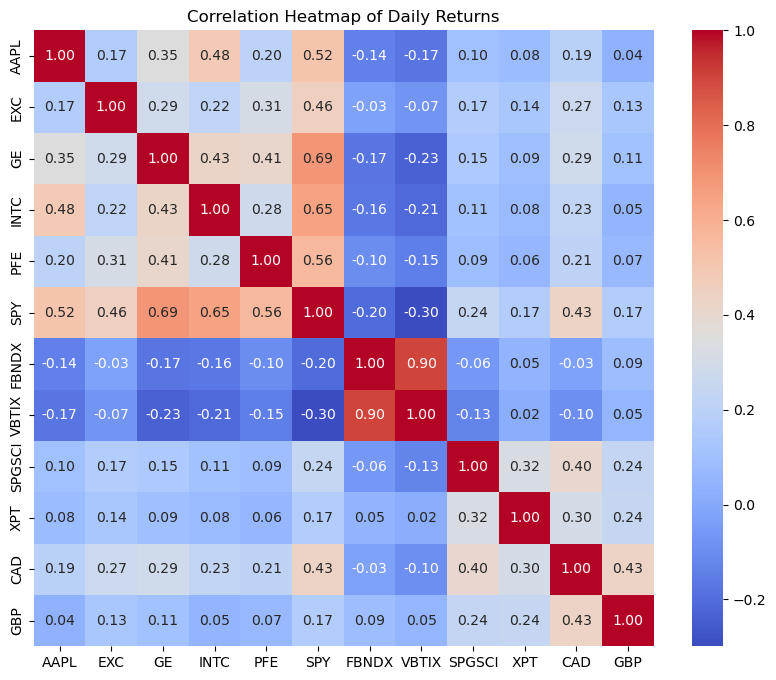

In [4]:
column_order = [0, 2, 5, 6, 7, 9, 3, 10, 8, 11, 1, 4]
dfPrices_reordered = dfPrices.iloc[:, column_order]

daily_returns_corr = dfPrices_reordered.pct_change().corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(daily_returns_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Daily Returns")
plt.show()

### Calculate Sharpe Ratios for all the securities for all the technical strategies

This code takes approximately 35 minutes to run. We have commented it out and saved the results in a later markdown cell.
The results can be reproduced by uncommenting it and running the cell.

In [5]:
# %%time
# def wrapper_from_scratch(stock_df):
#     sharpes_flat = []
#     sharpes_short = []
#     fast_windows = []
#     slow_windows = []

#     for fastWindow in range(5, 110):
#         for slowWindow in range(50, 500, 5):
#             if fastWindow < slowWindow:
#                 # MA crossover strategy
#                 df_crossover = movingAverageCrossover(stock_df.copy(), fastWindow, slowWindow)

#                 # Sharpe Ratios for both strategies
#                 sharpe_flat = df_crossover[stock_df.columns[0] +'-MAFlat'].mean() / df_crossover[stock_df.columns[0] +'-MAFlat'].std() * np.sqrt(260)
#                 sharpe_short = df_crossover[stock_df.columns[0] +'-MAShort'].mean() / df_crossover[stock_df.columns[0] +'-MAShort'].std() * np.sqrt(260)

#                 sharpes_flat.append(sharpe_flat)
#                 sharpes_short.append(sharpe_short)
#                 fast_windows.append(fastWindow)
#                 slow_windows.append(slowWindow)

#     # Convert the lists to numpy arrays
#     sharpes_flat = np.array(sharpes_flat)
#     sharpes_short = np.array(sharpes_short)
#     fast_windows = np.array(fast_windows)
#     slow_windows = np.array(slow_windows)

#     max_sharpe_flat_index = sharpes_flat.argmax()
#     max_sharpe_short_index = sharpes_short.argmax()

#     optimal_fast_flat = fast_windows[max_sharpe_flat_index]
#     optimal_slow_flat = slow_windows[max_sharpe_flat_index]
#     optimal_fast_short = fast_windows[max_sharpe_short_index]
#     optimal_slow_short = slow_windows[max_sharpe_short_index]

#     df_goFlat = movingAverageCrossover(stock_df.copy(), optimal_fast_flat, optimal_slow_flat)
#     df_goShort = movingAverageCrossover(stock_df.copy(), optimal_fast_short, optimal_slow_short)
    
    
#     sharpes_bb = []
#     lookback_windows = []
#     stdev_bands = []

#     for lookbackWindow in range(20, 50):
#         for stdevBand in range(2, 5):
#             # BB strategy returns
#             df_bollinger = bollingerBands(stock_df.copy(), lookbackWindow, stdevBand)

#             # Check if the strategy daily returns are all zero (no trades)
#             if df_bollinger[stock_df.columns[0] +'-BB'].abs().sum() == 0:
#                 continue  # Skip this combination

#             # Calculate Sharpe Ratio for the BB strategy
#             sharpe_bb = df_bollinger[stock_df.columns[0] +'-BB'].mean() / df_bollinger[stock_df.columns[0] +'-BB'].std() * np.sqrt(260)

#             sharpes_bb.append(sharpe_bb)
#             lookback_windows.append(lookbackWindow)
#             stdev_bands.append(stdevBand)

#     # Convert the lists to numpy arrays
#     sharpes_bb = np.array(sharpes_bb)
#     lookback_windows = np.array(lookback_windows)
#     stdev_bands = np.array(stdev_bands)

#     max_sharpe_bb_index = sharpes_bb.argmax()

#     optimal_lookback_window = lookback_windows[max_sharpe_bb_index]
#     optimal_stdev_band = stdev_bands[max_sharpe_bb_index]
#     max_sharpe_bb = sharpes_bb[max_sharpe_bb_index]
    
#     df_BB = bollingerBands(stock_df.copy(), optimal_lookback_window, optimal_stdev_band)
    
#     # BMK and MAFlat columns from go flat dataframe 
#     df_1 = df_goFlat[[stock_df.columns[0] +'-BMK', stock_df.columns[0] +'-MAFlat']]
#     # MAShort column from go short dataframe 
#     df_2 = df_goShort[[stock_df.columns[0] +'-MAShort']]
#     # BB column from BollingerBands dataframe 
#     df_3 = df_BB[[stock_df.columns[0] +'-BB']]
#     #inner join 
#     merged_df = df_1.join([df_2, df_3], how='inner')
#     return merged_df


# stats_columns = ['BMK', 'MAFlat', 'MAShort', 'BB'] 
# SR_alltickers = pd.DataFrame(columns = stats_columns)

# for index in range(len(dfPrices.columns)):
#     wrapper_df = wrapper_from_scratch(pd.DataFrame(dfPrices.iloc[:, index]))
#     summary_stats = calcSummaryStatistics(wrapper_df.dropna(), print_screen=False)
#     SR = pd.DataFrame(summary_stats.iloc[2, :]).T
#     SR.columns = stats_columns
#     SR.index = [dfPrices.iloc[:, index].name]
#     SR_alltickers = pd.concat([SR_alltickers, SR], axis=0)
# SR_alltickers.to_csv('temp.csv')
# SR_alltickers


In [6]:
# data contains the results from running the commented code above.
# It takes around 35 minutes to run, so we have just saved the result as is.
# It can be reproduced by simply uncommenting the cell above and running the code.
data = {
    "BMK": [0.721821, 0.049930, 0.069802, 0.154475, -0.098023, -0.337078, 0.003376, 0.003526, 0.120955, 0.185829, 0.157100, 0.094141],
    "MAFlat": [1.012515, 0.408297, 0.374060, 0.594255, 0.379804, 0.247552, 0.205217, 0.210192, 0.506139, 0.654915, 0.303740, 0.519437],
    "MAShort": [0.806178, 0.507899, 0.418420, 0.698702, 0.557126, 0.589420, 0.355448, 0.268598, 0.612787, 0.563825, 0.353973, 0.635677],
    "BB": [-0.096171, 0.214248, 0.243767, 0.233353, 0.175963, 0.348615, 0.446640, 0.488147, 0.016683, 0.359695, 0.250141, 0.265567]
}
index = [dfPrices.columns]
SR_alltickers = pd.DataFrame(data, index=index)

highlighted_df = SR_alltickers.style.highlight_max(color='lightgreen', axis=1)
highlighted_df

,BMK,MAFlat,MAShort,BB
AAPL,0.721821,1.012515,0.806178,-0.096171
CAD,0.049930,0.408297,0.507899,0.214248
EXC,0.069802,0.374060,0.418420,0.243767
FBNDX,0.154475,0.594255,0.698702,0.233353
GBP,-0.098023,0.379804,0.557126,0.175963
GE,-0.337078,0.247552,0.589420,0.348615
INTC,0.003376,0.205217,0.355448,0.446640
PFE,0.003526,0.210192,0.268598,0.488147
SPGSCI,0.120955,0.506139,0.612787,0.016683
SPY,0.185829,0.654915,0.563825,0.359695


Based on the table above, we chose the following securities, and the strategies 
- MAFLAT - AAPL, SPY
- MASHORT - FBNDX, GBP, GE, XPT
- BB - PFE, INTC

Among the 6 equities, we have - 
- AAPL - MAFlat - 1.012515
- SPY - MAFlat - 0.654915
- GE - MAShort - 0.589420
- PFE - BB - 0.488147
- INTC - BB - 0.446640
- EXC - MAShort - 0.418420

Among the 2 fixed income instruments, we have -
- FBNDX - MAShort - 0.698702
- VBTIX - MAShort - 0.353973

Among the 2 commodity instruments, we have -
- XPT - MAShort - 0.635677
- SPGSCI - MAShort - 0.612787

Among the 2 currency pairs, we have -
- GBP - MAShort - 0.557126
- CAD - MAShort - 0.507899

Based on the above results, we select, AAPL, SPY, GE, PFE, and INTC. These equities have the highest Sharpe Ratios among the 6 equities provided. Similarly we chose, FBNDX, XPT, and GBP to maximize Sharpe Ratios.

### Sensitivity Analysis to find optimum Fast Window and Slow Window for Equities

We will plot the Sharpe Ratios for different combinations of Slow Window (SW) and Fast Window (FW) below, and try to identify common areas which can be used for estimating optimal choice for a single SW, and FW.


In [7]:
def macrossover_strat(stock_df, x):
    """ Function to run sensitivity analysis on stock_df. If x = 0, then the function will run analysis on 
    Flat Moving Average Strategy, if it is 1, then it will run analysis on Short Moving Average Strategy.
    The output is the parameters necessary to construct a sensitivity plot for stock_df"""
    sharpes_flat = []
    sharpes_short = []
    fast_windows = []
    slow_windows = []
    
    if (x==0):
        for fastWindow in range(5, 110):
            for slowWindow in range(50, 500, 5):
                if fastWindow < slowWindow:
                    # MA crossover strategy
                    df_crossover = movingAverageCrossover(stock_df.copy(), fastWindow, slowWindow)

                    # Sharpe Ratios for both strategies
                    sharpe_flat = df_crossover[stock_df.columns[0] +'-MAFlat'].mean() / df_crossover[stock_df.columns[0] +'-MAFlat'].std() * np.sqrt(260)

                    sharpes_flat.append(sharpe_flat)
                    fast_windows.append(fastWindow)
                    slow_windows.append(slowWindow)
        # Convert the lists to numpy arrays
        sharpes_flat = np.array(sharpes_flat)
        fast_windows = np.array(fast_windows)
        slow_windows = np.array(slow_windows)
        max_sharpe_flat_index = sharpes_flat.argmax()
        optimal_fast_flat = fast_windows[max_sharpe_flat_index]
        optimal_slow_flat = slow_windows[max_sharpe_flat_index]
        return (fast_windows, slow_windows, sharpes_flat, max_sharpe_flat_index, optimal_fast_flat, optimal_slow_flat)

                
    elif (x==1):          
        for fastWindow in range(5, 110):
            for slowWindow in range(50, 500, 5):
                if fastWindow < slowWindow:
                    # MA crossover strategy
                    df_crossover = movingAverageCrossover(stock_df.copy(), fastWindow, slowWindow)

                    # Sharpe Ratios for both strategies
                    sharpe_short = df_crossover[stock_df.columns[0] +'-MAShort'].mean() / df_crossover[stock_df.columns[0] +'-MAShort'].std() * np.sqrt(260)

                    sharpes_short.append(sharpe_short)
                    fast_windows.append(fastWindow)
                    slow_windows.append(slowWindow)
        sharpes_short = np.array(sharpes_short)
        fast_windows = np.array(fast_windows)
        slow_windows = np.array(slow_windows)
        max_sharpe_short_index = sharpes_short.argmax()
        optimal_fast_short = fast_windows[max_sharpe_short_index]
        optimal_slow_short = slow_windows[max_sharpe_short_index]
        return (fast_windows, slow_windows, sharpes_short, max_sharpe_short_index, optimal_fast_short, optimal_slow_short)

In [8]:
%%time
# This code runs the above function for the following 6 securities.
# Time taken to run the code ~ 4 minutes
# We have 6 securities that we will run on Moving Average strategy and 2 on Bollinger Bands strategy

symbols_strategies = [('AAPL', 0), ('GE', 1), ('SPY', 0), ('FBNDX', 1), ('XPT', 1), ('GBP', 1)]
results = []
# Calculate data
for symbol, strategy in symbols_strategies:
    data = pd.DataFrame(dfPrices.loc[:, symbol])
    result = macrossover_strat(data, strategy)
    results.append(result)

CPU times: total: 3min 3s
Wall time: 3min 51s


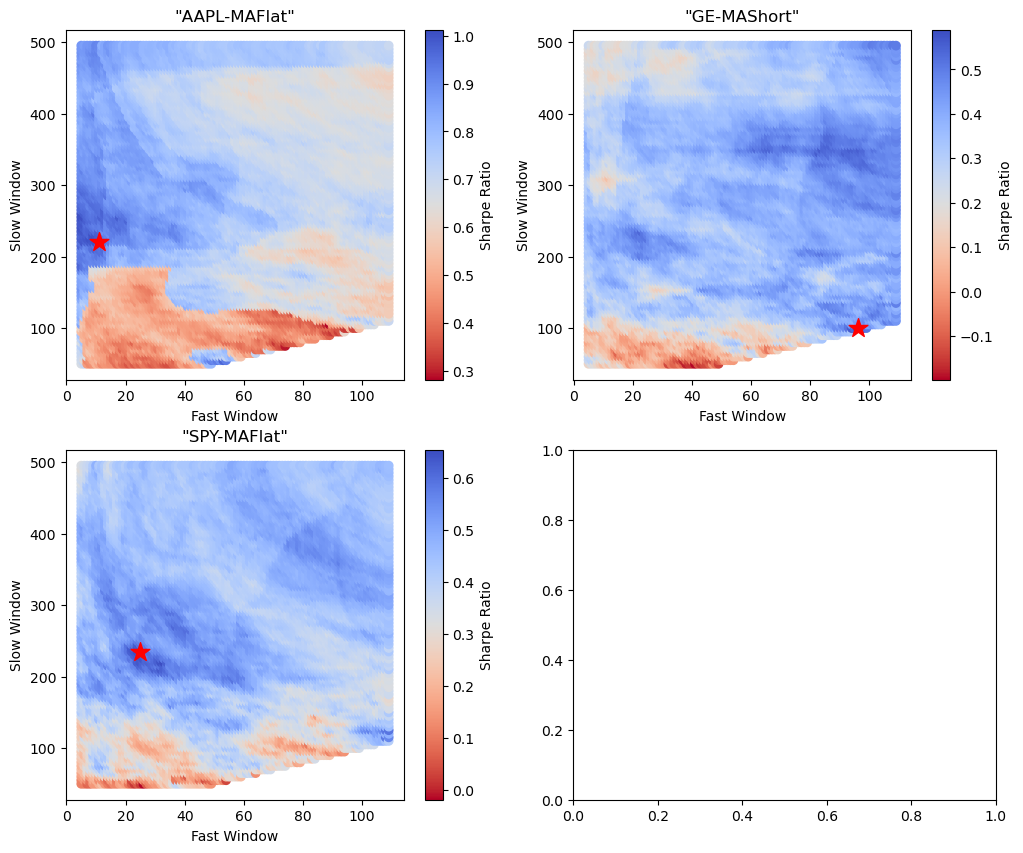

In [9]:
# Plotting sensitivity analysis for the first 3 strategies
# These 3 securities belong to the equitis and can share the same SW and FW
fig, axs = plt.subplots(2, 2, figsize=(12, 10)) 
titles = ['"AAPL-MAFlat"', '"GE-MAShort"', '"SPY-MAFlat"']

for i, (ax, title, (FWs, SWs, sharpes, max_sharpe_index, optimal_fast, optimal_slow)) in enumerate(zip(axs.flat, titles, results[:4])):
    scatter = ax.scatter(FWs, SWs, c=sharpes, cmap='coolwarm_r', marker='o')
    max_sharpe = sharpes[max_sharpe_index]
    ax.scatter(optimal_fast, optimal_slow, c='red', marker='*', s=200)
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Sharpe Ratio')
    ax.set_xlabel('Fast Window')
    ax.set_ylabel('Slow Window')
    ax.set_title(title)

plt.show()

We can observe from the above charts that the optimum SW and FW will lie around the following areas:
- Optimal Fast Window - [5, 50]
- Optimal Slow Window - [150, 300]


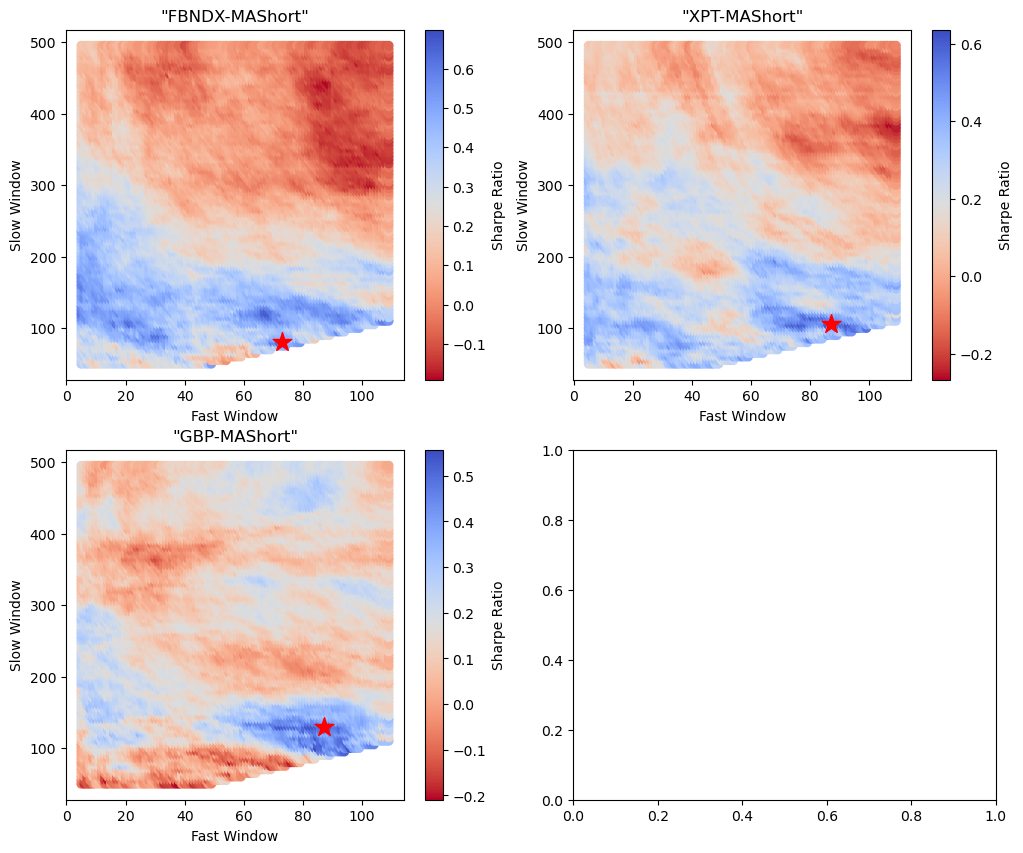

In [10]:
# Plotting sensitivity analysis for the last 3 moving average strategies
# These 3 securities belong to the non-equitis and can share the same SW and FW
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
titles = ['"FBNDX-MAShort"', '"XPT-MAShort"', '"GBP-MAShort"']

for i, (ax, title, (FWs, SWs, sharpes, max_sharpe_index, optimal_fast, optimal_slow)) in enumerate(zip(axs.flat, titles, results[3:])):
    scatter = ax.scatter(FWs, SWs, c=sharpes, cmap='coolwarm_r', marker='o')
    max_sharpe = sharpes[max_sharpe_index]
    ax.scatter(optimal_fast, optimal_slow, c='red', marker='*', s=200)
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Sharpe Ratio')
    ax.set_xlabel('Fast Window')
    ax.set_ylabel('Slow Window')
    ax.set_title(title)

plt.show()

We can observe from the above 3 charts that the optimum SW and FW will lie around the following areas:
- Optimal Fast Window - [70, 100]
- Optimal Slow Window - [70, 150]


We will try to identify the optimum SW and FW for the 3 securities in our equities. We will make a portfolio from their daily returns, and try to optimize the Sharpe Ratios for that portfolio. Our hypothesis is that the SW and FW found doing this will be the best for MA strategy. We hope to cross verify our findings by using the sensitivity analysis done above.

In [11]:
%%time
# Time taken to run ~ 2.5 minutes
sharpes_Total = []
fast_windows = []
slow_windows = []
gf = '-MAFlat'
gs = '-MAShort'

for fastWindow in range(5, 110):
    for slowWindow in range(50, 500, 5):
        if fastWindow < slowWindow:  
            df_crossover1= movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[0][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[0][0] + gf]] 
            df_crossover2 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[1][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[1][0] + gs]]
            df_crossover3 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[2][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[2][0] + gf]]
            
            # Perform inner join
            df_joined = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
            df_joined = pd.merge(df_joined, df_crossover3, left_index=True, right_index=True, how='inner')

            weightedPortfolio = pd.DataFrame({'Total': df_joined.sum(axis=1)})
            sharpe_Total = weightedPortfolio['Total'].mean() / weightedPortfolio['Total'].std() * np.sqrt(260)

            sharpes_Total.append(sharpe_Total)
            fast_windows.append(fastWindow)
            slow_windows.append(slowWindow)
            
# Convert the lists to numpy arrays
sharpes_Total = np.array(sharpes_Total)
fast_windows = np.array(fast_windows)
slow_windows = np.array(slow_windows)

max_sharpe_total_index = sharpes_Total.argmax()

optimal_fast_total = fast_windows[max_sharpe_total_index]
optimal_slow_total = slow_windows[max_sharpe_total_index]


CPU times: total: 1min 53s
Wall time: 2min 51s


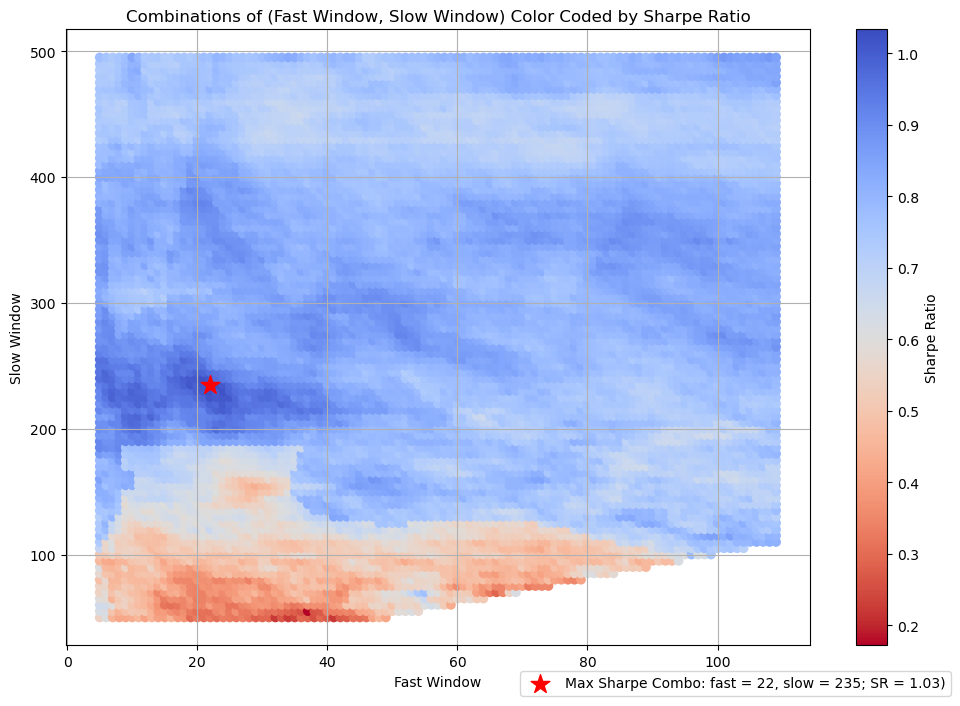

In [12]:
plt.figure(figsize = aspect_ratio)
scatter = plt.scatter(fast_windows, slow_windows, c=sharpes_Total, cmap='coolwarm_r', marker='o')

max_sharpe_Total = sharpes_Total[max_sharpe_total_index]
plt.scatter(optimal_fast_total, optimal_slow_total, c='red', marker='*', s=200, 
            label=f'Max Sharpe Combo: fast = {optimal_fast_total}, slow = {optimal_slow_total}; SR = {max_sharpe_Total:.2f})')
# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')
plt.xlabel('Fast Window')
plt.ylabel('Slow Window')
plt.title('Combinations of (Fast Window, Slow Window) Color Coded by Sharpe Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.90, -0.03), ncol=1)
# Display
plt.grid(True)
plt.show()


As seen above, our results matches in what we observed, and hence we will take the SW = 235, and FW = 22 for the MA strategies for the securities that belong to the equities category.

Now we will repeat the step for the non-equity securities.

In [13]:
%%time
# Time taken to run ~ 2.5 minutes
sharpes_Total = []
fast_windows = []
slow_windows = []
gf = '-MAFlat'
gs = '-MAShort'

for fastWindow in range(5, 110):
    for slowWindow in range(50, 500, 5):
        if fastWindow < slowWindow:  
            df_crossover1= movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[3][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[3][0] + gs]] 
            df_crossover2 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[4][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[4][0] + gs]]
            df_crossover3 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[5][0]].copy()),
                                                                                                fastWindow, slowWindow)[[symbols_strategies[5][0] + gs]]
            # Perform inner join
            df_joined = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
            df_joined = pd.merge(df_joined, df_crossover3, left_index=True, right_index=True, how='inner')

            weightedPortfolio = pd.DataFrame({'Total': df_joined.sum(axis=1)})
            sharpe_Total = weightedPortfolio['Total'].mean() / weightedPortfolio['Total'].std() * np.sqrt(260)

            sharpes_Total.append(sharpe_Total)
            fast_windows.append(fastWindow)
            slow_windows.append(slowWindow)
            
# Convert the lists to numpy arrays
sharpes_Total = np.array(sharpes_Total)
fast_windows = np.array(fast_windows)
slow_windows = np.array(slow_windows)

max_sharpe_total_index = sharpes_Total.argmax()

optimal_fast_total = fast_windows[max_sharpe_total_index]
optimal_slow_total = slow_windows[max_sharpe_total_index]


CPU times: total: 1min 50s
Wall time: 2min 34s


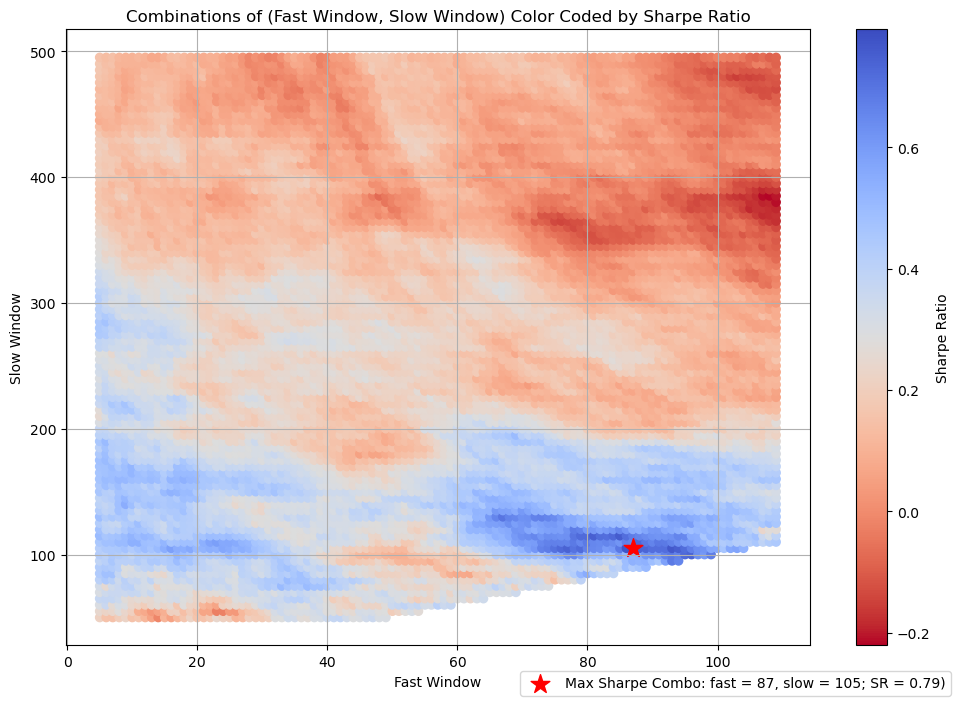

In [14]:
plt.figure(figsize = aspect_ratio)
scatter = plt.scatter(fast_windows, slow_windows, c=sharpes_Total, cmap='coolwarm_r', marker='o')

max_sharpe_Total = sharpes_Total[max_sharpe_total_index]
plt.scatter(optimal_fast_total, optimal_slow_total, c='red', marker='*', s=200, 
            label=f'Max Sharpe Combo: fast = {optimal_fast_total}, slow = {optimal_slow_total}; SR = {max_sharpe_Total:.2f})')
# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')
plt.xlabel('Fast Window')
plt.ylabel('Slow Window')
plt.title('Combinations of (Fast Window, Slow Window) Color Coded by Sharpe Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.90, -0.03), ncol=1)
# Display
plt.grid(True)
plt.show()


Our results match for this calculation as well. Optimum SW = 105, and optimum FW = 87

Now we will calculate the optimum lookback Window and STdev Band for the Bollinger Band securities which are PFE and INTC. We will use the similar approach of making a portfolio as shown for the Moving Average Strategies to finalize the parameters. 

In [15]:
%%time
# Time taken to run ~ 4 minutes
sharpes_bb = []
lookback_windows = []
stdev_bands = []


for lookbackWindow in range(20, 50):
    for stdevBand in range(2, 5):
        # BB strategy returns
        df_bollinger1 = bollingerBands(dfPrices[['PFE']].copy(), lookbackWindow, stdevBand)[['PFE' + '-BB']] 
        df_bollinger2 = bollingerBands(dfPrices[['INTC']].copy(), lookbackWindow, stdevBand)[['INTC' + '-BB']]
        
        df_bollinger = pd.merge(df_bollinger1, df_bollinger2, left_index=True, right_index=True, how='inner')
        weightedPortfolio = pd.DataFrame({'Total': df_bollinger.sum(axis=1)})
            
        # Check if the strategy daily returns are all zero (no trades)
        if weightedPortfolio['Total'].abs().sum() == 0:
            continue  # Skip this combinationa
        
        # Calculate Sharpe Ratio for the BB strategy
        sharpe_bb = weightedPortfolio['Total'].mean() / weightedPortfolio['Total'].std() * np.sqrt(260)
        
        sharpes_bb.append(sharpe_bb)
        lookback_windows.append(lookbackWindow)
        stdev_bands.append(stdevBand)

# Convert the lists to numpy arrays
sharpes_bb = np.array(sharpes_bb)
lookback_windows = np.array(lookback_windows)
stdev_bands = np.array(stdev_bands)

max_sharpe_bb_index = sharpes_bb.argmax()

optimal_lookback_window = lookback_windows[max_sharpe_bb_index]
optimal_stdev_band = stdev_bands[max_sharpe_bb_index]
max_sharpe_bb = sharpes_bb[max_sharpe_bb_index]

print("Optimal Bollinger Bands Strategy: Lookback Window =", optimal_lookback_window, "Standard Deviation Band =", optimal_stdev_band)
print("Max Sharpe Ratio =", max_sharpe_bb)

Optimal Bollinger Bands Strategy: Lookback Window = 22 Standard Deviation Band = 2
Max Sharpe Ratio = 0.5460277039535656
CPU times: total: 3min 2s
Wall time: 4min 23s


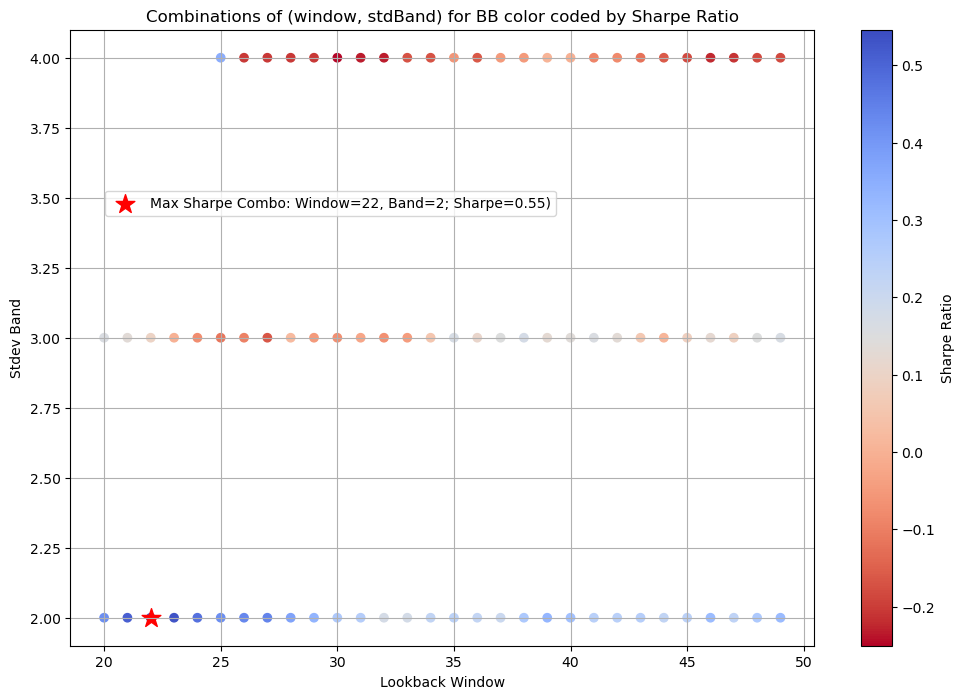

In [16]:
plt.figure(figsize=aspect_ratio)
scatter = plt.scatter(lookback_windows, stdev_bands, c=sharpes_bb, cmap='coolwarm_r', marker='o')

# Mark the maximum Sharpe point with a red star
plt.scatter(optimal_lookback_window, optimal_stdev_band, c='red', marker='*', s=200,
            label=f'Max Sharpe Combo: Window={optimal_lookback_window}, Band={optimal_stdev_band}; Sharpe={max_sharpe_bb:.2f})')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')
plt.xlabel('Lookback Window')
plt.ylabel('Stdev Band')
plt.title('Combinations of (window, stdBand) for BB color coded by Sharpe Ratio')
plt.legend(loc='upper center', bbox_to_anchor=(0.35, 0.75), ncol=1)

# Display
plt.grid(True)
plt.show()


The optimum Lookback Window = 22 and Standard Deviation Band = 2 for the PFE security using the Bollinger Bands strategy

Re-calculating the daily returns using the strategies and the optimum parameters evaluated above, and merging them into a single dataframe.

While looking for better strategies, we found that if we use MAShort for SPY and MAFlat for FBNDX, we will be able to get a much better Sharpe. So we used these strategies here while making the final portfolio. We kept the SW and the FW same (as calculated above) for our calculations and hence were in line with the constraints. It increased the SR of our strategy from 1.421 to 1.430.

In [17]:
df_crossover1= movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[0][0]].copy()),
                                      22, 235)[[symbols_strategies[0][0] + gf]] # AAPL
df_crossover2 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[1][0]].copy()),
                                       22, 235)[[symbols_strategies[1][0] + gs]] # GE
df_crossover3 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[2][0]].copy()),
                                       22, 235)[[symbols_strategies[2][0] + gs]] # SPY
df_crossover4 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[3][0]].copy()),
                                       87, 105)[[symbols_strategies[3][0] + gf]] # FBNDX
df_crossover5= movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[4][0]].copy()),
                                      87, 105)[[symbols_strategies[4][0] + gs]]  # XPT
df_crossover6 = movingAverageCrossover(pd.DataFrame(dfPrices.loc[:, symbols_strategies[5][0]].copy()),
                                       87, 105)[[symbols_strategies[5][0] + gs]] # GBP
df_crossover7 = bollingerBands(dfPrices[['INTC']].copy(), 22, 2)[['INTC-BB']]
df_crossover8 = bollingerBands(dfPrices[['PFE']].copy(), 22, 2)[['PFE-BB']]

In [18]:
df_merged = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover3, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover4, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover5, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover6, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover7, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_crossover8, left_index=True, right_index=True, how='inner')
df_merged = df_merged[1:]

In [19]:
print_pct_data(df_merged.head())

,AAPL-MAFlat,GE-MAShort,SPY-MAShort,FBNDX-MAFlat,XPT-MAShort,GBP-MAShort,INTC-BB,PFE-BB
Date,,,,,,,,
2000-12-05 00:00:00,0.0000%,-4.7290%,-3.2283%,0.4240%,-1.1263%,1.3524%,8.8907%,0.0000%
2000-12-06 00:00:00,-0.0000%,0.3470%,1.6127%,0.2817%,-2.1260%,-0.8206%,-12.5626%,-0.0000%
2000-12-07 00:00:00,0.0000%,0.8144%,1.3816%,0.1405%,1.4115%,-0.0623%,1.7561%,0.0000%
2000-12-08 00:00:00,0.0000%,-3.1055%,-0.2335%,-0.1405%,-0.7689%,-0.4833%,5.0906%,0.0000%
2000-12-11 00:00:00,0.0000%,-0.2262%,-3.4166%,0.0000%,1.0781%,-0.3438%,9.6312%,0.0000%


# 3. Rationale of our choices

In [20]:
highlighted_df

,BMK,MAFlat,MAShort,BB
AAPL,0.721821,1.012515,0.806178,-0.096171
CAD,0.049930,0.408297,0.507899,0.214248
EXC,0.069802,0.374060,0.418420,0.243767
FBNDX,0.154475,0.594255,0.698702,0.233353
GBP,-0.098023,0.379804,0.557126,0.175963
GE,-0.337078,0.247552,0.589420,0.348615
INTC,0.003376,0.205217,0.355448,0.446640
PFE,0.003526,0.210192,0.268598,0.488147
SPGSCI,0.120955,0.506139,0.612787,0.016683
SPY,0.185829,0.654915,0.563825,0.359695


First we tried to find the correlations in the daily returns for each of the securities and to identify any security that stands out. We couldn't find any security that stands out, so we checked for the Sharpe Ratio values.

Then we proceeded to calculate Sharpe Ratios for all the securities for all the technical strategies. We chose the best parameters for these technical strategies. For example, the Sharpe Ratio in the table for MA-Flat strategy for any stock will be calculated for the optimum FW and SW. It is the same case for all the stocks and all the securities. We planned to select the securities and the best possible strategy for each security. <br>

From the table above were able to select the strategies and the securities, as follows:
- MAFLAT - AAPL, SPY
- MASHORT - FBNDX, GBP, GE, XPT
- BB - PFE, INTC

While looking for better strategies, we found that if we use MAShort for SPY and MAFlat for FBNDX, we will be able to get a much better Sharpe. So we used these strategies here while making the final portfolio. We kept the SW and the FW same for our calculations and hence were in line with the constraints. It increased the SR of our strategy from 1.421 to 1.430.
- MAFLAT - AAPL, FBNDX
- MASHORT - SPY, GBP, GE, XPT
- BB - PFE, INTC

These securities had the best Sharpe Ratio among their categories (equities, currency pairs, etc.). Also, the strategy chosen for these securities had the best Sharpe Ratios as well.

Our rationale was that even though the securities will have a different Sharpe Ratio after we adhere to the guidelines of the question, the SR of the portfolio will not be lowered by a large factor. Now we proceed to do sensitivity analysis and find the optimum Slow window and Fast window for the 4 equities, and 2 non-equities. We also planned to find optimal Standard Deviation and Lookback Window for the 2 securities in the Bolinger Bands strategy.

First we plotted the Combinations plot for the 3 equities: AAPL, SPY, and GE to identify the possible blue regions which can collectively contribute to increase the Sharpe of the portfolio. We had a general idea of where this SW and FW will lie. Upon further analysis, by making a portfolio (equal weighted) of just three categories, we were able to see that the optimum SR lie in the SW = 235, FW = 22. We did a similar analysis on the on-equity securities, FBNDX, GBP, and XPT, and were able to get the optimal SW = 105, and FW = 87.

Upon making an equal weighted portfolio for the two strategies in the Bollinger Bands: PFE and INTC, we were able to get the optimal SW and FW by maximizing for the Sharpe Ratio of this portfolio. The parameters we got were: Lookback Window = 22, Standard Deviation Band = 2 

Our conclusion is that even though our portfolio may not perform as good as the one hinted via the table above, it will still perform much better than arbitrarily choosing any security and strategy. We believe our choice of strategies to be optimal because we were able to quantitatively substantiate our choice of strategies and securities.

# 4. Reordering the columns 

The columns are already named according to the conventions so we will reorder them.

In [21]:
# Place PFE-BB to first position
column_order = ['PFE-BB'] + [col for col in df_merged.columns if col != 'PFE-BB']
column_order = ['INTC-BB'] + [col for col in column_order if col != 'INTC-BB']
# Sort the first 5 columns alphabetically
sorted_columns = sorted(column_order[0:5])
new_column_order = [sorted_columns + column_order[5:]]
# Reorder the columns in the DataFrame
df_merged = df_merged[new_column_order[0]]
print_pct_data(df_merged.head())

,AAPL-MAFlat,GE-MAShort,INTC-BB,PFE-BB,SPY-MAShort,FBNDX-MAFlat,XPT-MAShort,GBP-MAShort
Date,,,,,,,,
2000-12-05 00:00:00,0.0000%,-4.7290%,8.8907%,0.0000%,-3.2283%,0.4240%,-1.1263%,1.3524%
2000-12-06 00:00:00,-0.0000%,0.3470%,-12.5626%,-0.0000%,1.6127%,0.2817%,-2.1260%,-0.8206%
2000-12-07 00:00:00,0.0000%,0.8144%,1.7561%,0.0000%,1.3816%,0.1405%,1.4115%,-0.0623%
2000-12-08 00:00:00,0.0000%,-3.1055%,5.0906%,0.0000%,-0.2335%,-0.1405%,-0.7689%,-0.4833%
2000-12-11 00:00:00,0.0000%,-0.2262%,9.6312%,0.0000%,-3.4166%,0.0000%,1.0781%,-0.3438%


In [22]:
myPortfolioColumns = list(df_merged.columns)
print('myPortfolioColumns =', myPortfolioColumns)

myPortfolioColumns = ['AAPL-MAFlat', 'GE-MAShort', 'INTC-BB', 'PFE-BB', 'SPY-MAShort', 'FBNDX-MAFlat', 'XPT-MAShort', 'GBP-MAShort']


# 5. Calculating Correlations

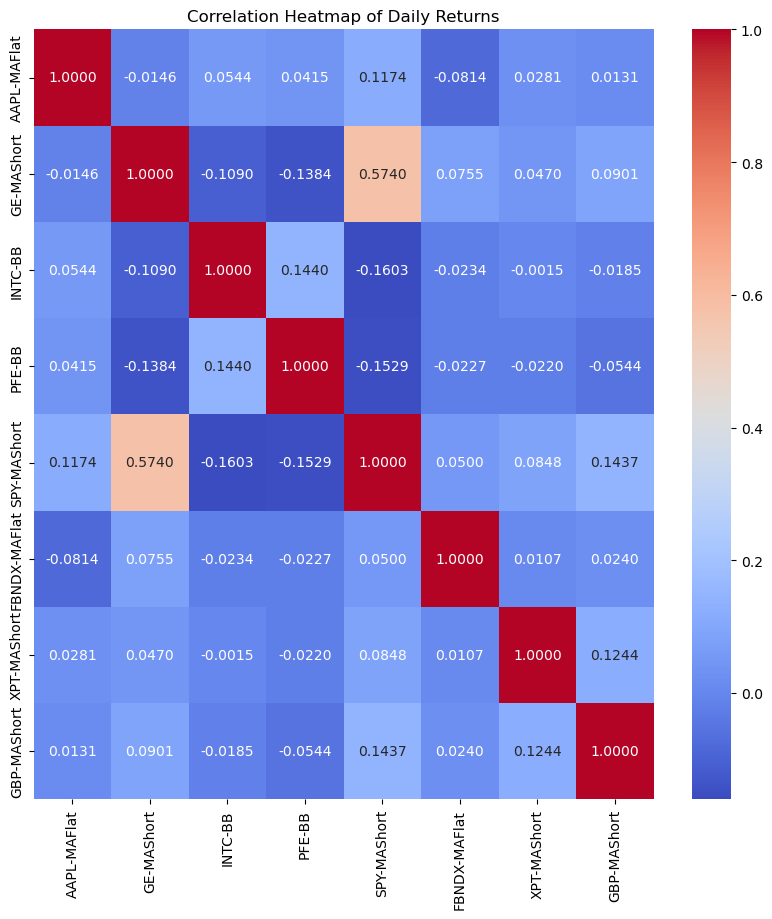

In [23]:
# Create the heatmap
plt.figure(figsize=(10, 10))  # Adjust the size as needed
sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation Heatmap of Daily Returns")
plt.show()

Comments on Correlation Structure 

Overall there are very few correlations in our portfolio, the only notable high correlation being between GE and SPY. This is a good thing, because it will help us to diversif our risks when we form our final weighted portfolio. All the other relationships were very close to 0 hence this will help us in diversification of risk in our portfolio.

Positive relationship: if the securities have a positive relationship, they will move (increase/decrease) together in the same way. AAPL-MAFlat & SPY-MAFlat, AAPL-MAFlat & INTC-BB, AAPL-MAFlat & PFE-BB, and INTC-MAFlat & PFE-BB have a positive relationship / positive correlation with 0.1174, 0.0544, 0.0415, and 0.1440 respectively. The most notable positive correlation was between GE-MAShort & SPY-MAShort of 0.5740.

Negative relationship: if the securities have a negative relationship, they will move opposite. Therefore, securities with negative correlations can mitigate volatility. GE-MAShort and PFE-BB have a negative relationship with a correlation of -0.1385. AAPL-MAFlat & GE-MAShort, AAPL-MAFlat & FBNDX-MAShort, PFE-BB & XPT-MAShort, PFE-BB & GBP-MAShort, and SPY-MAFlat & FBNDX-MAShort have a slightly negative relationship with correlation. 

Neutral relationship: If the correlation = 0, there's no relationship. 
In our case, there's no correlation = 0. But there are some securities that have a slightly positive, but almost neutral relationship (correlation is almost 0). 

## 6. Making Equal Weight Portfolios

Matrix Formulation for portfolio return and risk. 

Portfolio Return = weights * return transpose 

Portfolio Risk = np.sqrt(weights * return covariance matrix * weight transpose)

Annual Sharpe Ratio = np.sqrt(annualization_factor) * Portfolio Return / Portfolio Risk

In [24]:
# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
equal_weight = np.array([1/8]*8)
annualization_factor = 260

annual_sharpe = np.sqrt(annualization_factor) * np.dot(equal_weight, df_merged.mean().T) / np.sqrt(np.dot(np.dot(equal_weight, df_merged.cov()), equal_weight.T))
annual_sharpe

1.3580500907597812

In [25]:
#sharpe ratio for df_merged
pd.DataFrame(np.sqrt(annualization_factor)*df_merged.mean()/df_merged.std(), columns=['Sharpe Ratio'])

,Sharpe Ratio
AAPL-MAFlat,0.910103
GE-MAShort,0.522358
INTC-BB,0.425637
PFE-BB,0.488684
SPY-MAShort,0.525463
FBNDX-MAFlat,0.308159
XPT-MAShort,0.585966
GBP-MAShort,0.518729


The equal-weight portfolio outperforms every individual strategy (AAPL-MAFlat, GE-MAShort, INTC-BB, PFE-BB, SPY-MAShort, FBNDX-MAFlat, XPT-MAShort, GBP-MAShort). SR for the equal-weight portfolio is 1.3580500907597812 which is much larger than the highest SR of 0.910103 for AAPL-MAFlat.

# 7 Generating the Efficient Frontier & Plotting risk and return scatter plot

In [26]:
%%time
# Takes around 8 seconds to run
#Q7 Generating the Efficient frontier and calculating weights
# Number of simulations
num_portfolios = 5000

annualization_factor = 260
rng = np.random.default_rng(seed=64)

all_weights = np.zeros((num_portfolios, df_merged.shape[1]))
portfolio_returns = np.zeros(num_portfolios)
portfolio_volatilities = np.zeros(num_portfolios)
sharpe_ratios = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Generating random weights
    wts = rng.random(df_merged.shape[1])
    wts /= np.sum(wts)  # normalizing the weights to 100%

    # Save weights
    all_weights[i, :] = wts

    # Expected portfolio return
    portfolio_returns[i] = np.sum(wts * df_merged.mean()) * annualization_factor

    # Expected portfolio volatility
    portfolio_volatilities[i] = np.sqrt(np.dot(wts.T, np.dot(df_merged.cov() * annualization_factor, wts)))

    # Sharpe Ratio
    sharpe_ratios[i] = portfolio_returns[i] / portfolio_volatilities[i]

CPU times: total: 20.3 s
Wall time: 9.5 s


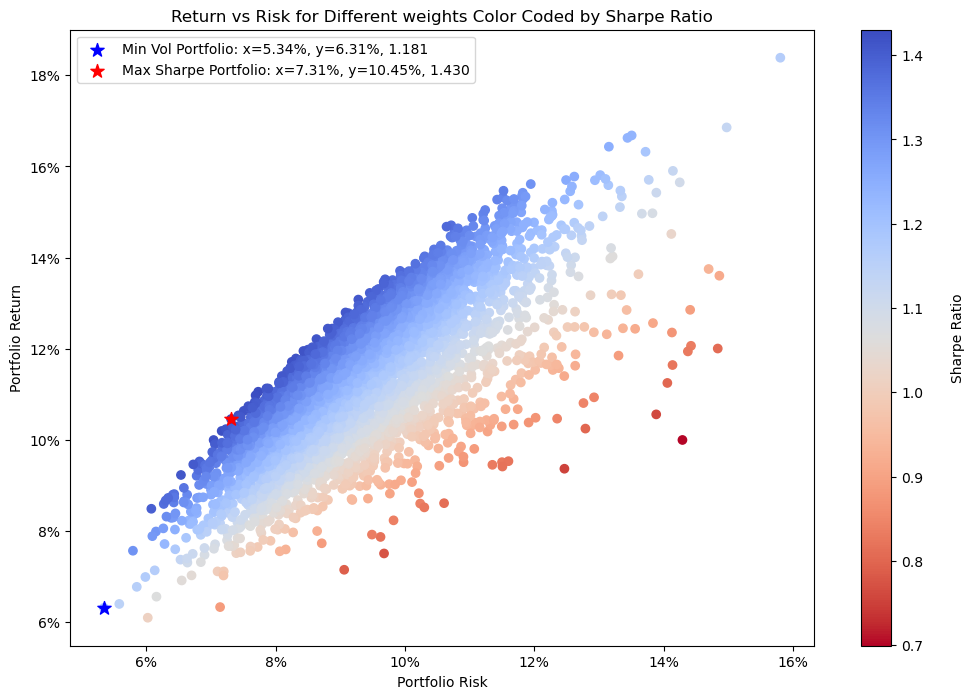

In [27]:
# 8. Adjust x and y axis to percentage format
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Including a colorbar based on Sharpe Ratio
sc = plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratios, cmap='coolwarm_r', marker='o')
plt.colorbar(sc, label='Sharpe Ratio').set_label('Sharpe Ratio', rotation=90, labelpad=20)
plt.title('Return vs Risk for Different weights Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')

# 9. Minimum Volatility Portfolio
min_vol_idx = np.argmin(portfolio_volatilities)
min_vol_plot = plt.scatter(portfolio_volatilities[min_vol_idx], portfolio_returns[min_vol_idx], color='b', marker='*', s=100)

# 10. Maximum Sharpe Ratio Portfolio
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_plot = plt.scatter(portfolio_volatilities[max_sharpe_idx], portfolio_returns[max_sharpe_idx], color='r', marker='*', s=100)

# 9-10. Construct a legend for these two stars
min_vol_text = f"Min Vol Portfolio: x={portfolio_volatilities[min_vol_idx]:.2%}, y={portfolio_returns[min_vol_idx]:.2%}, {sharpe_ratios[min_vol_idx]:.3f}"
max_sharpe_text = f"Max Sharpe Portfolio: x={portfolio_volatilities[max_sharpe_idx]:.2%}, y={portfolio_returns[max_sharpe_idx]:.2%}, {sharpe_ratios[max_sharpe_idx]:.3f}"
plt.legend(handles=[min_vol_plot, max_sharpe_plot], labels=[min_vol_text, max_sharpe_text], loc='upper left', fontsize='medium')
plt.show()

In [28]:
#7. identify the weights of the minimum-vol and the maximum-Sharpe portfolios. 
weights_df = pd.DataFrame([all_weights[min_vol_idx], all_weights[max_sharpe_idx]], columns=myPortfolioColumns, index=['Min Vol', 'Max Sharpe']).T
display(print_pct_data(weights_df))


,Min Vol,Max Sharpe
AAPL-MAFlat,3.3531%,14.6776%
GE-MAShort,6.5368%,7.1009%
INTC-BB,12.7068%,9.5478%
PFE-BB,14.6145%,14.1931%
SPY-MAShort,4.7980%,5.3683%
FBNDX-MAFlat,51.4682%,22.0983%
XPT-MAShort,5.1900%,14.3070%
GBP-MAShort,1.3325%,12.7069%


# Rationalizing Weights for Minimum Vol Portfolio

We need to consider the underlying characteristics and risk profiles of each asset, as well as how they interact with each other in terms of diversification and correlation.

- High Weight in FBNDX (51.4682%): Fidelity Investment Grade Bond Index (FBNDX) carries a significantly high weight. Bonds, particularly investment-grade ones, are generally less volatile than equities. This high allocation to FBNDX suggests a strong preference for stability and income, typical for our minimum volatility.
- Moderate Weights in Equities (AAPL, GE, INTC, PFE, SPY): The allocation to equities like AAPL, GE, INTC, PFE, and SPY is more moderate. Among these: AAPL and PFE: Both have substantial allocations (around 14%), which might reflect their relatively stable performance history or specific market conditions favoring technology and pharmaceutical sectors. GE and SPY: These have lower weights compared to AAPL and PFE, possibly due to their broader exposure to market volatility. INTC: This has a moderate weight (12.7068%), suggesting a balanced approach to technology sector exposure.
- Lower Weights in Commodities and Currency (XPT, GBP): Commodities and currencies can be volatile. The lower allocations to Platinum (XPT) and the British Pound (GBP) indicate a cautious approach to these potentially more volatile assets, consistent with the goal of minimizing volatility.

# Rationalizing Weights for Maximum Sharpe Portfolio

The Maximum Sharpe Portfolio aims to maximize the risk-adjusted return, focusing on balancing high returns with controlled volatility. Each asset's allocation reflects its expected contribution to this goal, considering individual performance characteristics and inter-asset correlations.

- High Weight in FBNDX (22.0983%): The substantial allocation to the Fidelity Investment Grade Bond Index (FBNDX) highlights a preference for stability and income, which is typical in strategies aiming for higher Sharpe ratios. As a bond fund, FBNDX likely offers lower volatility and provides a stabilizing effect, balancing the riskier equity positions.
- Substantial Allocations in Equities (AAPL, GE, INTC, PFE, SPY): AAPL (14.6776%) and PFE (14.1931%): These stocks have significant weights, potentially due to their historical performance stability and growth prospects. Apple, as a tech leader, and Pfizer, a major pharmaceutical company, may offer a combination of growth and resilience. GE (7.1009%): General Electric's moderate weight could reflect its diversified nature as a high-tech industrial company, offering exposure to different sectors with moderate risk. INTC (9.5478%): Intel's allocation might be driven by its role in the technology sector, which can offer growth but with considerable volatility. SPY (5.3683%): The S&P 500 ETF provides broad market exposure. Its relatively lower weight might indicate a strategy leaning towards selective stock picking over market-wide exposure, optimizing for risk-adjusted returns.
- Targeted Exposure in Commodities and Currency (XPT, GBP): XPT (14.3070%): Platinum's notable weight suggests a strategic positioning to leverage its unique attributes, such as inflation hedging or industrial demand, while also adding diversification benefits. GBP (12.7069%): The British Pound's significant allocation implies a strategic forex play, possibly for hedging against currency risks or capitalizing on specific currency market dynamics.

# 8. Calculating Sharpe of Maximum Sharpe portfolio from above

In [29]:
# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
optimum_weight = weights_df['Max Sharpe'].values
annualization_factor = 260

max_sharpe = np.sqrt(annualization_factor) * np.dot(optimum_weight, df_merged.mean().T) / np.sqrt(np.dot(np.dot(optimum_weight, df_merged.cov()), optimum_weight.T))
max_sharpe

1.4301871754039084

The sharpe ratio of equal-weight portfolio is 1.3580500907597812. On the other hand, the sharpe ratio of max-sharpe's weight portfolio is 1.4301871754039084. Therefore, the sharpe ratio of maximum-sharpe portfolio is higher than the sharpe ratio of equal-weight portfolio. 

In [30]:
weights_df['Max Sharpe']

AAPL-MAFlat     0.146776
GE-MAShort      0.071009
INTC-BB         0.095478
PFE-BB          0.141931
SPY-MAShort     0.053683
FBNDX-MAFlat    0.220983
XPT-MAShort     0.143070
GBP-MAShort     0.127069
Name: Max Sharpe, dtype: float64

# 9. Making the Max Sharpe Portfolio

In [31]:
df_merged['Max Sharpe Portfolio'] = df_merged.mul(weights_df['Max Sharpe']).sum(axis=1)
print_pct_data(df_merged.head())

,AAPL-MAFlat,GE-MAShort,INTC-BB,PFE-BB,SPY-MAShort,FBNDX-MAFlat,XPT-MAShort,GBP-MAShort,Max Sharpe Portfolio
Date,,,,,,,,,
2000-12-05 00:00:00,0.0000%,-4.7290%,8.8907%,0.0000%,-3.2283%,0.4240%,-1.1263%,1.3524%,0.4442%
2000-12-06 00:00:00,-0.0000%,0.3470%,-12.5626%,-0.0000%,1.6127%,0.2817%,-2.1260%,-0.8206%,-1.4344%
2000-12-07 00:00:00,0.0000%,0.8144%,1.7561%,0.0000%,1.3816%,0.1405%,1.4115%,-0.0623%,0.5248%
2000-12-08 00:00:00,0.0000%,-3.1055%,5.0906%,0.0000%,-0.2335%,-0.1405%,-0.7689%,-0.4833%,0.0505%
2000-12-11 00:00:00,0.0000%,-0.2262%,9.6312%,0.0000%,-3.4166%,0.0000%,1.0781%,-0.3438%,0.8306%


In [32]:
calcSummaryStatistics(df_merged, print_screen=True)

Summary Statistics for Returns:


,AAPL-MAFlat,GE-MAShort,INTC-BB,PFE-BB,SPY-MAShort,FBNDX-MAFlat,XPT-MAShort,GBP-MAShort,Max Sharpe Portfolio
Average Annual Return,25.48%,16.19%,11.06%,9.09%,10.16%,0.85%,13.00%,4.94%,10.45%
Annual Risk,28.00%,30.99%,25.98%,18.59%,19.33%,2.75%,22.18%,9.51%,7.31%
Sharpe Ratio,0.910103,0.522358,0.425637,0.488684,0.525463,0.308159,0.585966,0.518729,1.430187
maxDD,-1543.26%,-513.64%,-115.78%,-79.48%,-114.11%,-10.06%,-815.95%,-37.21%,-38.35%
Success Ratio,65.46%,52.10%,74.65%,74.10%,53.66%,80.59%,52.67%,51.40%,54.15%


The summary statistics of our maximum Sharpe portfolio:
- Average Annual Return (10.45%): The return of the Max Sharpe portfolio is higher than some individual components (PFE, SPY, FBNDX, XPT, GBP) while lower than others (AAPL, GE, INTC). This suggests a balanced approach, combining high and moderate return assets.
- Annual Risk (7.31%): The portfolio has significantly lower risk compared to most individual stocks, with only the FBNDX (a bond fund) having a lower risk profile. This lower risk is indicative of effective diversification and risk management within our portfolio.
- Sharpe Ratio (1.430187): The Sharpe Ratio of the portfolio is substantially higher than any individual component, indicating a superior risk-adjusted return.
- Maximum Drawdown (maxDD -38.35%): The portfolio's maxDD is lower than most of the equity components, suggesting better downside risk management.
- Success Ratio (54.15%): The portfolio's success ratio is around the mid-range when compared to individual components. This suggests a balanced approach to capturing upside while mitigating downside risks.

# 10. Calculating Beta

A beta value of 0.057 for your maximum Sharpe portfolio relative to the S&P 500 indicates that the portfolio is significantly less volatile than the market. This low beta suggests that the portfolio's returns are expected to be much less sensitive to market movements. In essence, it implies that the portfolio is much more stable and less affected by market swings, which is consistent with a conservative investment strategy prioritizing risk minimization.

In [33]:
dfBeta = pd.merge(dfPrices[['SPY']].pct_change(), df_merged[['Max Sharpe Portfolio']], left_index=True, right_index=True, how='inner')
dfBeta = dfBeta.dropna()
X = dfBeta[['SPY']]
X = sm.add_constant(X)
y = dfBeta['Max Sharpe Portfolio']
max_SR_Reg = sm.OLS(y, X).fit()
max_SR_Reg.params.SPY

0.05680084415031094

# 11. Comparing Portfolios 

We choose the following securities in Step 2:
- Equities - AAPL, INTC, GE, PFE, SPY
- Fixed income instrument - FBNDX
- Commodity instrument - XPT
- Currency - GBP

We choose following parameters for our portfolio:
- Sliding Windows for the equities - Slow Window = 235, Fast Window = 22
- Sliding Windows for rest of the instruments - Slow Window = 105, Fast Window = 87
- Lookback Window and Stddev for the Bollinger Band Strategy - Lookback Window = 22, Standard Deviation Band = 2

Sharpe Ratios for all the strategies mentioned in the question
- SR for the Benchmark strategy across all securities: 0.1991708458923862
- SR for the MA-Flat strategy across all securities: 0.7051172671884972
- SR for the MA-Short strategy across all securities: 0.6459001202612928
- SR for the Bollinger Bands strategy across all securities: 0.06036277020550035
- SR for the maximum Sharpe Portfolio: 1.4318216720337964

None of the these 4 portfolios outperform our chosen Max Sharpe portfolio from Q10.

In [34]:
df_crossover1 = movingAverageCrossover(dfPrices[['AAPL']].copy(), 22, 235)['AAPL-BMK']
df_crossover2 = movingAverageCrossover(dfPrices[['INTC']].copy(), 22, 235)['INTC-BMK']
df_crossover3 = movingAverageCrossover(dfPrices[['GE']].copy(), 22, 235)['GE-BMK']
df_crossover4 = movingAverageCrossover(dfPrices[['PFE']].copy(), 22, 235)['PFE-BMK']
df_crossover5 = movingAverageCrossover(dfPrices[['SPY']].copy(), 22, 235)['SPY-BMK']
df_crossover6 = movingAverageCrossover(dfPrices[['FBNDX']].copy(), 87, 105)['FBNDX-BMK']
df_crossover7 = movingAverageCrossover(dfPrices[['XPT']].copy(), 87, 105)['XPT-BMK']
df_crossover8 = movingAverageCrossover(dfPrices[['GBP']].copy(), 87, 105)['GBP-BMK']

df_bmk = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover3, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover4, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover5, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover6, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover7, left_index=True, right_index=True, how='inner')
df_bmk = pd.merge(df_bmk, df_crossover8, left_index=True, right_index=True, how='inner')
df_bmk = df_bmk.loc[df_bmk.index >= min(df_merged.index)]

# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
equal_weight = np.array([1/df_bmk.shape[1]]*df_bmk.shape[1])
annualization_factor = 260

annual_sharpe = np.sqrt(annualization_factor) * np.dot(equal_weight, df_bmk.mean().T) / np.sqrt(np.dot(np.dot(equal_weight, df_bmk.cov()), equal_weight.T))
annual_sharpe

0.1991708458923862

In [35]:
df_crossover1 = movingAverageCrossover(dfPrices[['AAPL']].copy(), 22, 235)['AAPL-MAFlat']
df_crossover2 = movingAverageCrossover(dfPrices[['INTC']].copy(), 22, 235)['INTC-MAFlat']
df_crossover3 = movingAverageCrossover(dfPrices[['GE']].copy(), 22, 235)['GE-MAFlat']
df_crossover4 = movingAverageCrossover(dfPrices[['PFE']].copy(), 22, 235)['PFE-MAFlat']
df_crossover5 = movingAverageCrossover(dfPrices[['SPY']].copy(), 22, 235)['SPY-MAFlat']
df_crossover6 = movingAverageCrossover(dfPrices[['FBNDX']].copy(), 87, 105)['FBNDX-MAFlat']
df_crossover7 = movingAverageCrossover(dfPrices[['XPT']].copy(), 87, 105)['XPT-MAFlat']
df_crossover8 = movingAverageCrossover(dfPrices[['GBP']].copy(), 87, 105)['GBP-MAFlat']

df_flat = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover3, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover4, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover5, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover6, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover7, left_index=True, right_index=True, how='inner')
df_flat = pd.merge(df_flat, df_crossover8, left_index=True, right_index=True, how='inner')
df_flat = df_flat.loc[df_flat.index >= min(df_merged.index)]

# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
equal_weight = np.array([1/df_flat.shape[1]]*df_flat.shape[1])
annualization_factor = 260

annual_sharpe = np.sqrt(annualization_factor) * np.dot(equal_weight, df_flat.mean().T) / np.sqrt(np.dot(np.dot(equal_weight, df_flat.cov()), equal_weight.T))
annual_sharpe

0.7051172671884972

In [36]:
df_crossover1 = movingAverageCrossover(dfPrices[['AAPL']].copy(), 22, 235)['AAPL-MAShort']
df_crossover2 = movingAverageCrossover(dfPrices[['INTC']].copy(), 22, 235)['INTC-MAShort']
df_crossover3 = movingAverageCrossover(dfPrices[['GE']].copy(), 22, 235)['GE-MAShort']
df_crossover4 = movingAverageCrossover(dfPrices[['PFE']].copy(), 22, 235)['PFE-MAShort']
df_crossover5 = movingAverageCrossover(dfPrices[['SPY']].copy(), 22, 235)['SPY-MAShort']
df_crossover6 = movingAverageCrossover(dfPrices[['FBNDX']].copy(), 87, 105)['FBNDX-MAShort']
df_crossover7 = movingAverageCrossover(dfPrices[['XPT']].copy(), 87, 105)['XPT-MAShort']
df_crossover8 = movingAverageCrossover(dfPrices[['GBP']].copy(), 87, 105)['GBP-MAShort']

df_short = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover3, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover4, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover5, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover6, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover7, left_index=True, right_index=True, how='inner')
df_short = pd.merge(df_short, df_crossover8, left_index=True, right_index=True, how='inner')
df_short = df_short.loc[df_short.index >= min(df_merged.index)]

# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
equal_weight = np.array([1/df_short.shape[1]]*df_short.shape[1])
annualization_factor = 260

annual_sharpe = np.sqrt(annualization_factor) * np.dot(equal_weight, df_short.mean().T) / np.sqrt(np.dot(np.dot(equal_weight, df_short.cov()), equal_weight.T))
annual_sharpe

0.6459001202612928

In [37]:
df_crossover1 = bollingerBands(dfPrices[['AAPL']].copy(), 22, 2)[['AAPL-BB']]
df_crossover2 = bollingerBands(dfPrices[['INTC']].copy(), 22, 2)[['INTC-BB']]
df_crossover3 = bollingerBands(dfPrices[['GE']].copy(), 22, 2)[['GE-BB']]
df_crossover4 = bollingerBands(dfPrices[['SPY']].copy(), 22, 2)[['SPY-BB']]
df_crossover5 = bollingerBands(dfPrices[['PFE']].copy(), 22, 2)[['PFE-BB']]
df_crossover6 = bollingerBands(dfPrices[['FBNDX']].copy(), 22, 2)[['FBNDX-BB']]
df_crossover7 = bollingerBands(dfPrices[['XPT']].copy(), 22, 2)[['XPT-BB']]
df_crossover8 = bollingerBands(dfPrices[['GBP']].copy(), 22, 2)[['GBP-BB']]

df_bb = pd.merge(df_crossover1, df_crossover2, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover3, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover4, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover5, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover6, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover7, left_index=True, right_index=True, how='inner')
df_bb = pd.merge(df_bb, df_crossover8, left_index=True, right_index=True, how='inner')
df_bb = df_bb.loc[df_bb.index >= min(df_merged.index)]

# Calculate sharpe ratio, using matrix formulation of portfolio Return and Risk
equal_weight = np.array([1/df_bb.shape[1]]*df_bb.shape[1])
annualization_factor = 260

annual_sharpe = np.sqrt(annualization_factor) * np.dot(equal_weight, df_bb.mean().T) / np.sqrt(np.dot(np.dot(equal_weight, df_bb.cov()), equal_weight.T))
annual_sharpe

0.06036277020550035